In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import talib as ta
from trend_v1 import *
import copy as cp
import warnings
warnings.filterwarnings('ignore')

<h3>First here, I tried to detect the turning points like last time I showed you</h3>

In [2]:
def data_collection(filename):
    Folder_data = '../Data/'
    data = pd.read_csv(Folder_data +filename)
    data.reset_index(drop=True, inplace=True)
    data.info()
    return data

In [3]:
def plot_pivots(data,pivots):
    plt.figure(figsize = (15,10))
    plt.xlim(0, len(data))
    plt.ylim(data.min()*0.99, data.max()*1.01)
    plt.plot(np.arange(len(data)), data, 'k:', alpha=0.5)
    plt.plot(np.arange(len(data))[pivots != 0], data[pivots != 0], 'k-')
    plt.scatter(np.arange(len(data))[pivots == 1], data[pivots == 1], color='g')
    plt.scatter(np.arange(len(data))[pivots == -1], data[pivots == -1], color='r')

In [4]:
EU_Build = data_collection('EU_H1_Build.csv')
EU_Build.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62399 entries, 0 to 62398
Data columns (total 6 columns):
Local time    62399 non-null object
Open          62399 non-null float64
High          62399 non-null float64
Low           62399 non-null float64
Close         62399 non-null float64
Volume        62399 non-null float64
dtypes: float64(5), object(1)
memory usage: 2.9+ MB


,Local time,Open,High,Low,Close,Volume
62394,13.07.2018 18:00:00.000 GMT+0200,1.16665,1.16776,1.16653,1.16733,10647.7695
62395,13.07.2018 19:00:00.000 GMT+0200,1.16733,1.16755,1.16660,1.16755,9190.4004
62396,13.07.2018 20:00:00.000 GMT+0200,1.16756,1.16828,1.16739,1.16767,7812.7700
62397,13.07.2018 21:00:00.000 GMT+0200,1.16768,1.16838,1.16757,1.16810,7784.0000
62398,13.07.2018 22:00:00.000 GMT+0200,1.16812,1.16868,1.16809,1.16843,4402.7002


In [5]:
EU_Build.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62399 entries, 0 to 62398
Data columns (total 6 columns):
Local time    62399 non-null object
Open          62399 non-null float64
High          62399 non-null float64
Low           62399 non-null float64
Close         62399 non-null float64
Volume        62399 non-null float64
dtypes: float64(5), object(1)
memory usage: 2.9+ MB


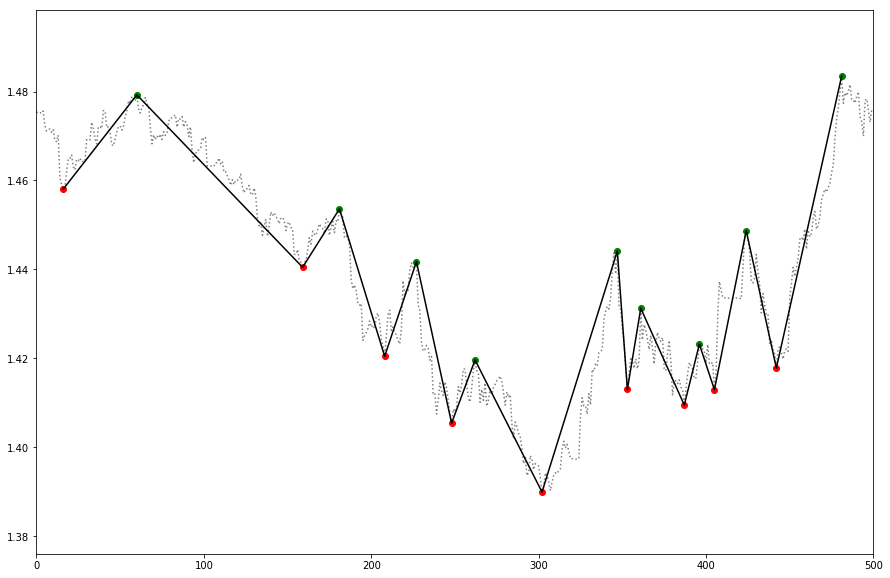

In [6]:
trend_build = trend_v1(EU_Build,0.006,-0.006) # 0.005 which means if there is a change of 50 pips, the trend is reversal.
first_pivot_build = trend_build.initial_pivot()
pivots_build = trend_build.peak_valley_pivots(first_pivot_build)
EU_Build['Pivots'] = pivots_build
plot_pivots(EU_Build['Close'][500:1000],EU_Build['Pivots'][500:1000])

In [7]:
CCI_build = ta.CCI(EU_Build['High'], EU_Build['Low'], EU_Build['Close'], timeperiod=14)
RSI_build = ta.RSI(EU_Build['Close'], timeperiod=14)
EU_Build['CCI'] = CCI_build
EU_Build['RSI'] = RSI_build

In [8]:
df_build = EU_Build.where(EU_Build['Pivots']!=0)
df_build = df_build.dropna()
df_build = df_build.reset_index(drop=True)

d_H1_build = np.zeros(len(df_build['Close']))

for i in range(1,len(df_build['Close'])):
    d_H1_build[i] = df_build['Close'][i] - df_build['Close'][i-1]
    
#Distance is the amount of change between 2 Pivots points
df_build['Distance'] = d_H1_build
df_build.head(5)

,Local time,Open,High,Low,Close,Volume,Pivots,CCI,RSI,Distance
0,30.07.2008 15:00:00.000 GMT+0200,1.55492,1.55550,1.55183,1.55386,39627.9961,-1.0,-267.842682,30.108848,0.00000
1,31.07.2008 14:00:00.000 GMT+0200,1.56108,1.56842,1.55996,1.56761,40775.8945,1.0,182.893143,72.292200,0.01375
2,11.08.2008 01:00:00.000 GMT+0200,1.49516,1.49654,1.49189,1.49321,12670.9971,-1.0,-145.339757,14.451766,-0.07440
3,11.08.2008 10:00:00.000 GMT+0200,1.50320,1.50835,1.50250,1.50758,46006.3945,1.0,215.591993,54.477264,0.01437
4,12.08.2008 07:00:00.000 GMT+0200,1.48806,1.48908,1.48188,1.48292,28809.9004,-1.0,-206.553208,28.125896,-0.02466


<h3>Now I would like generate a new dataframe, whhich include the change between last pivots points and the strength in indicators CCI and RSI at that point. Based on the previous change, I will predict how much change will happen in the next move </h3>

In [9]:
Slide_data = df_build[["CCI","RSI","Distance"]]
Slide_data.head(5)

,CCI,RSI,Distance
0,-267.842682,30.108848,0.00000
1,182.893143,72.292200,0.01375
2,-145.339757,14.451766,-0.07440
3,215.591993,54.477264,0.01437
4,-206.553208,28.125896,-0.02466


<h3>Here I created a function window, which I consider window of 5 last elements in data to predict the next one</h3>

In [10]:
class WindowSlider(object):    
    def __init__(self, window_size):        
        self.w = window_size
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []              
    def collect_windows(self, X):
        cols = len(list(X)) - 1
        N = len(X)
        self.l = N - self.w
        self.p = cols * self.w + 1
        x = cp.deepcopy(X)       
        for j, col in enumerate(list(x)):                        
            for i in range(self.w):               
                name = col + ('(%d)' % (i+1))
                self.names.append(name)          
        self.names.append('Y')

        df = pd.DataFrame(np.zeros(shape=(self.l,len(self.names))), columns=self.names)
        
        for i in range(self.l):
            slices = np.array([])
            for k in range(len(list(X))):
                line = X.values[i:self.w + i, k]
                slices = np.concatenate((slices, line))
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices,y)) 
            df.iloc[i,:] = slices 
        return df

In [11]:
train_set = Slide_data[:1000].reset_index(drop=True)
test_set = Slide_data[1000:].reset_index(drop=True)

<h3>The table below is showed how the window works. They will consider all 5 last elements to predict the next change. Y is the distance would be in the next move </h3>

In [12]:
w = 3
train_win = WindowSlider(w)
train = train_win.collect_windows(train_set.iloc[:,0:])

test_win = WindowSlider(w)
test = test_win.collect_windows(test_set.iloc[:,0:])

train.head(5)

,CCI(1),CCI(2),CCI(3),RSI(1),RSI(2),RSI(3),Distance(1),Distance(2),Distance(3),Y
0,-267.842682,182.893143,-145.339757,30.108848,72.292200,14.451766,0.00000,0.01375,-0.07440,0.01437
1,182.893143,-145.339757,215.591993,72.292200,14.451766,54.477264,0.01375,-0.07440,0.01437,-0.02466
2,-145.339757,215.591993,-206.553208,14.451766,54.477264,28.125896,-0.07440,0.01437,-0.02466,0.01145
3,215.591993,-206.553208,155.503452,54.477264,28.125896,55.929682,0.01437,-0.02466,0.01145,-0.02814
4,-206.553208,155.503452,-142.079980,28.125896,55.929682,27.553291,-0.02466,0.01145,-0.02814,0.00987


RMSE = 0.01


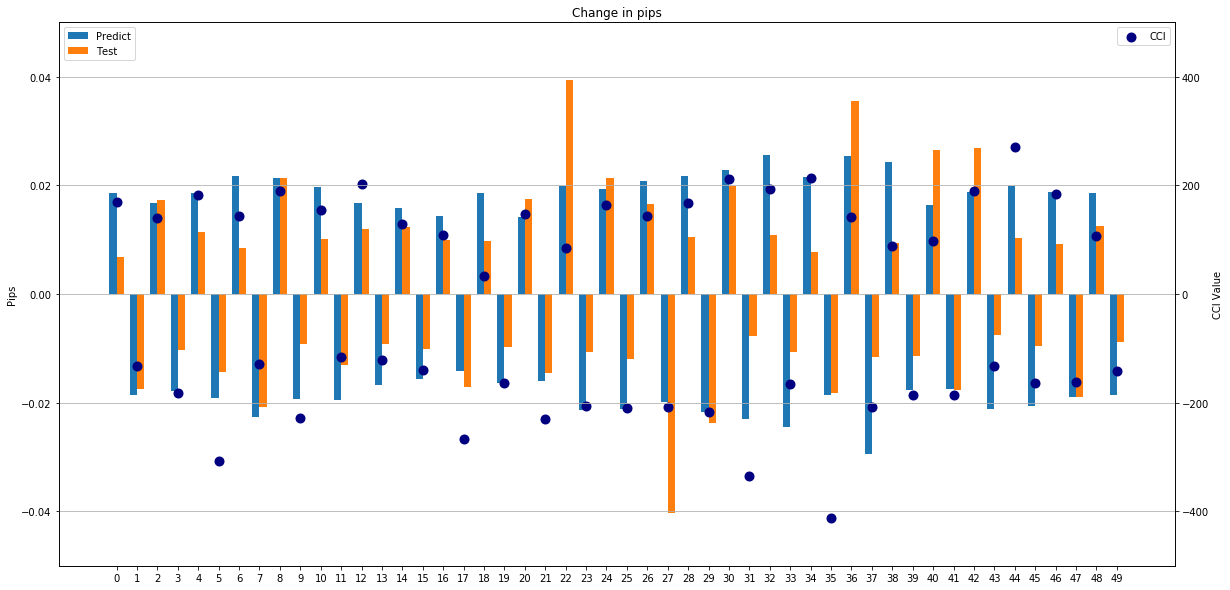

In [13]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train.iloc[:,:-1], train.iloc[:,-1])

lr_y = test['Y'].values
lr_y_fit = lr_model.predict(train.iloc[:,:-1])
lr_y_pred = lr_model.predict(test.iloc[:,:-1])

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)

results = pd.DataFrame()
results['Test'] = lr_y.tolist()
results['Predict'] = lr_y_pred.tolist()
results['CCI']=0
for i in range(len(results['Test'])):
    results['CCI'][i] = test_set['CCI'][i+w]
x = np.arange(len(results['Predict'][200:250]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (20,10))
lr_predict = ax.bar(x - width/2, results['Predict'][200:250], width, label='Predict')
lr_test_reg = ax.bar(x + width/2, results['Test'][200:250], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pips')
ax.set_title('Change in pips')
ax.set_xticks(x)
ax.set_ylim(-0.05,0.05)
ax.legend(loc=2)
ax2 = ax.twinx()
ax2.set_ylabel('CCI Value')
ax2.scatter(ax.get_xticks(),results['CCI'][200:250],marker='o', c='navy', linewidth=4)
ax2.set_ylim(-500,500)
ax2.legend(loc=1)
ax2.grid()
plt.show()

<h3>Overview: </h3><br>
    1. As can we see from the chart, the predicted distance run by SVR fluctuate in range from -0.015-0.015, which is 150 Percentage in point(pips) in price. 
<br><br>
    2. Some extremely high move, which is more than 300 pips, the model cannot detect.
<br><br>
    3. There are still some points, the model can predict quite correctly.<br>
    
<h3>Analysis: </h3><br>
    1. By my experience, in 1-Hour timeframe, it is recommended that a wave could last for 100-150 pips. In this model, they also shown the fluctuation of the model also in 150 pips, and they cannot detect the extremly high or small move of the market.
    Thus, I feel this model is not really work as I expect.
<br> <br>   
    2. I tried to change the window size from 2 to 10 and higher, and the window = 5 is the most reasonable. 
    

<h3>
In a nutshell:
</h3>
<br>
1. In this approach way, when I used the turning point to dectect the trend, I set a threshold value is 0.005, which is 50 pips. It means, after a change in a direction of 50 pips, it confirms reversal trend. So the model actually cannot detect the turning point in real time. They would have a delay after 50 pips. In a big move of 150-300 pips, it is still acceptable, but in a short move of 70-100 pips, this delay would make the orders become less profitable. On the otherhand, in a short move, when the market reverses, the model also will get some delay time to detect it! The threshold value is also a recommended value in real trading, and when I tried to reduce the value, I got much noisy data.
<br>
<br>
2. In the first approach, we faced to a constant move of the model, and they cannot detect the extremly high or low. The constant returned is also widely recommended in trading world, thus it is quite excessive.
<br>
<br>
3. In the second approach, we faced to a delay in return price. At some point you can see, the market has already reversed, but the predicted price is still going to the peak.


<h4> Stragetry:</h4>

Below, I tried to do a stragety for the first approach, by using the **Sliding window**, **Turning points** and **SVR**. To reduce the effect of the delay, and to obtain the best signal. In my exp, even when we detect the peak points, I will go to check the value of indicators, and in this time, it is CCI.

The Strong reversed point is the point that has the CCI value high than 180 ( Sell point), or lower than -180 (Buy point). Other Peak points, which have the CCI values from 180 to -180 are just the consolidation in a big trend.

The code is not finished yet.

In [14]:
EU_Trade = data_collection('EU_H1_Trade.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12623 entries, 0 to 12622
Data columns (total 6 columns):
Local time    12623 non-null object
Open          12623 non-null float64
High          12623 non-null float64
Low           12623 non-null float64
Close         12623 non-null float64
Volume        12623 non-null float64
dtypes: float64(5), object(1)
memory usage: 591.8+ KB


In [15]:
Balance = 100000
trade_order = 0
size_order = 0
take_profit_point = 0
stop_loss_point = 0
enter_price = 0
last_pivot_price = 0
pnl = 0 #Profit and loss

<img src="mapping.PNG">

<img src="Strategy.PNG">

In [16]:
df_report = pd.DataFrame(columns=['Trend threshold', 'CCI threshold', 'Lot size threshold','Profit and loss','Number of trade','Average gain per trade','Max loss','Max gain'])

In [25]:
trend_threshold_set = {0.003,0.005,0.007}
CCI_threshold_set = {200,180,160}
ext_size_lot_set = {1,0.8,0.6}
w = 3
df_report_test_1 = df_report.copy()
# I tried to run a simulation from 17.08.2018  to 25.10.2018, with 1H timeframe.
for trend_threshold in trend_threshold_set:
    for CCI_threshold in CCI_threshold_set:
        for ext_size_lot in ext_size_lot_set:
            profit_loss = []
            final_profit_loss = []
            capital = 100000
            trade_order = 0
            size_order = 0
            take_profit_point = 0
            stop_loss_point = 0
            enter_price = 0
            last_pivot_price = 0
            pnl = 0
            remain_capital = []
            for i in range(601,1800):
                data_trade = EU_Trade[i-600:i]
                data_trade.reset_index(inplace=True,drop=True)
                trend_trade = trend_v1(data_trade,trend_threshold,-trend_threshold)
                first_pivot_trade = trend_trade.initial_pivot()
                pivots_trade = trend_trade.peak_valley_pivots(first_pivot_trade)
                data_trade['Pivots'] = pivots_trade
                CCI_trade = ta.CCI(data_trade['High'], data_trade['Low'], data_trade['Close'], timeperiod=14)
                RSI_trade = ta.RSI(data_trade['Close'], timeperiod=14)
                data_trade['CCI'] = CCI_trade
                data_trade['RSI'] = RSI_trade
                df_trade = data_trade.where(data_trade['Pivots']!=0)
                df_trade = df_trade.dropna()
                df_trade = df_trade.reset_index(drop=True)

                d_trade = np.zeros(len(df_trade['Close']))
                for i in range(1,len(df_trade['Close'])):
                    d_trade[i] = df_trade['Close'][i] - df_trade['Close'][i-1]
                df_trade['Distance'] = d_trade

                #Check whether a new pivots points updated?
                if last_pivot_price != df_trade['Close'].iloc[-2]:
                    last_pivot_price = df_trade['Close'].iloc[-2]
                    #If yes, Close the current order, and update the it to the report
                    if trade_order == -1:
                        last_pivot_price = df_trade['Close'].iloc[-2]
                        pnl = -(enter_price - EU_Trade['Close'][i] ) * size_order
                        trade_order = 0
                    elif trade_order == 1:
                        last_pivot_price = df_trade['Close'].iloc[-2]
                        pnl = -(EU_Trade['Close'][i] - enter_price) * size_order
                        trade_order = 0
                    profit_loss.append(pnl)
                    pnl = 0    
                    #Predict the next move
                    df_next_move = df_trade[["CCI","RSI","Distance"]].tail(4)
                    df_next_move.reset_index(inplace=True,drop = True)
                    predict_win = WindowSlider(w)
                    predict_sett = predict_win.collect_windows(df_next_move.iloc[:,0:])
                    predict_distance = lr_model.predict(predict_sett.iloc[:,:-1])  
                    predict_sett = predict_sett.iloc[0:0]
                    #Enter Buy/Sell Order
                    #Buy order:
                    if df_trade['CCI'].iloc[-2] <= -CCI_threshold: #When market in Strongly oversold period
                        trade_order = 1
                        size_order = ext_size_lot * 100000 
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] - 0.002 
                        loss_d = stop_loss_point - enter_price
                        profit_d = predict_distance[0] - (enter_price - df_trade['Close'][i])
                        take_profit_point= enter_price + profit_d

                    elif 0 >= df_trade['CCI'].iloc[-2] > -CCI_threshold:  #When market in oversold period
                        trade_order = 1
                        size_order = 1 * 100000 #1lot
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] - 0.002 
                        loss_d = stop_loss_point - enter_price
                        profit_d = predict_distance[0] - (enter_price - df_trade['Close'][i])
                        take_profit_point= enter_price + profit_d

                    #Sell order:
                    elif df_trade['CCI'].iloc[-2] >= CCI_threshold: #When market in Strongly ovebought period
                        trade_order = -1
                        size_order = ext_size_lot * 100000 #
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] + 0.002 
                        loss_d = enter_price - stop_loss_point
                        profit_d = predict_distance[0] + (df_trade['Close'][i]-enter_price)
                        take_profit_point= df_trade['Close'][i] + profit_d

                    elif CCI_threshold > df_trade['CCI'].iloc[-2] > 0: #When market in ovebought period
                        trade_order = -1
                        size_order = 1 * 100000 #1 lot
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] + 0.002 
                        loss_d = enter_price - stop_loss_point
                        profit_d = predict_distance[0] + (df_trade['Close'][i]-enter_price)
                        take_profit_point= df_trade['Close'][i] + profit_d
                    #df_repor=df_report.append({'Order Type':trade_order,'Profit and loss':pnl},ignore_index=True)    
                else:
                    #if trade_order == 0:
                    #   break
                    #Check if a Buy order exist
                    if trade_order == 1:
                        if data_trade['High'][i] >= take_profit_point:
                            pnl = profit_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        elif data_trade['Low'][i] <= stop_loss_point:
                            pnl = loss_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        pnl = 0

                    elif trade_order == -1:
                        if data_trade['Low'][i] <= take_profit_point:
                            pnl = profit_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        elif data_trade['High'][i] >= stop_loss_point:
                            pnl = loss_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        pnl = 0              
                    #df_repor=df_report.append({'Order Type':trade_order,'Profit and loss':pnl},ignore_index=True)

            final_profit_loss = list(set(profit_loss))  
            print("Trend threshold: %.3f - CCI threshold: %d - the lot threshold: %.2f - Profit or loss:%.2f" %(trend_threshold,CCI_threshold,ext_size_lot,sum(final_profit_loss)))
            '''
            print(" -Number of trade is: %d" %len(final_profit_loss))
            print(" -The average gain per trade is: %.2f" %(sum(final_profit_loss)/len(final_profit_loss)))
            print(" -Max Loss in this in case is: %.2f" %min(final_profit_loss))
            print(" -Max Gain in this in case is: %.2f" %max(final_profit_loss))
            '''
            df_report_test_1=df_report_test_1.append({'Trend threshold':trend_threshold, 'CCI threshold':CCI_threshold, 'Lot size threshold':ext_size_lot,'Profit and loss':sum(final_profit_loss),'Number of trade':len(final_profit_loss),'Average gain per trade':(sum(final_profit_loss)/len(final_profit_loss)),'Max loss':min(final_profit_loss),'Max gain':max(final_profit_loss)}, ignore_index=True)
df_report_test_1.to_csv('df_report_test_1.csv')

Trend threshold: 0.003 - CCI threshold: 200 - the lot threshold: 0.80 - Profit or loss:24187.04
Trend threshold: 0.003 - CCI threshold: 200 - the lot threshold: 1.00 - Profit or loss:25528.05
Trend threshold: 0.003 - CCI threshold: 200 - the lot threshold: 0.60 - Profit or loss:22846.03
Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 0.80 - Profit or loss:24084.99
Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 1.00 - Profit or loss:25528.05
Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 0.60 - Profit or loss:22641.93
Trend threshold: 0.003 - CCI threshold: 160 - the lot threshold: 0.80 - Profit or loss:23688.05
Trend threshold: 0.003 - CCI threshold: 160 - the lot threshold: 1.00 - Profit or loss:25528.05
Trend threshold: 0.003 - CCI threshold: 160 - the lot threshold: 0.60 - Profit or loss:21848.06
Trend threshold: 0.005 - CCI threshold: 200 - the lot threshold: 0.80 - Profit or loss:7796.49
Trend threshold: 0.005 - CCI threshold: 2

In [26]:
df_report_test_1

,Trend threshold,CCI threshold,Lot size threshold,Profit and loss,Number of trade,Average gain per trade,Max loss,Max gain
0,0.003,200.0,0.8,24187.041642,54.0,447.908179,-1688.839066,2746.0
1,0.003,200.0,1.0,25528.052782,54.0,472.741718,-1688.839066,2886.0
2,0.003,200.0,0.6,22846.030502,54.0,423.074639,-1688.839066,2746.0
3,0.003,180.0,0.8,24084.989534,54.0,446.018325,-1688.839066,2746.0
4,0.003,180.0,1.0,25528.052782,54.0,472.741718,-1688.839066,2886.0
5,0.003,180.0,0.6,22641.926286,54.0,419.294931,-1688.839066,2746.0
6,0.003,160.0,0.8,23688.054277,54.0,438.667672,-1688.839066,2746.0
7,0.003,160.0,1.0,25528.052782,54.0,472.741718,-1688.839066,2886.0
8,0.003,160.0,0.6,21848.055772,54.0,404.593625,-1688.839066,2746.0
9,0.005,200.0,0.8,7796.490790,25.0,311.859632,-701.000000,1997.0


<h3>In the first test, we can see that:</h3>

    - The trend threshold 0.003 (Which is 30 pips) gain the highest profit in all, while the threshold 0.007 gian the smallest. 
    
    - The trend threshold 0.003 also has the highest number of trades, highest loss and profit per trade.
    
    - With the same trend threshold and lot size threshold, there is no much different between CCI threshold 180 and 200. The CCI threshold 160 gain less profit, but in some case (trend threshold 0.005 and 0.007), the max loss per trade is smaller than.
    
    - With the same trend threshold and CCI threshold, the lot size threshold 1.0 in extreme market usually gains much profit than the lot size threshold 0.8 and 0.6. However, the higher lot size threshold most of the time bring the higher **max loss** per trade. 
    
    - In some case, the **max loss** and **max gain** does not depend on the CCI threshold, and lot size threshold. It means the they happen in the normal market condition and there could be some abnormal events happend.
    
    - The **average gain per trade** of trend threshold 0.003 is highest.
    
    - **Max gain** is almost higher than **max loss** in all cases.

<h4>Based on the result from the first test, I am using a set of new trend threshold {0.003, 0.004, 0.005}, CCI threshold is 180 and lot size threshold {1, 0.6}, to test the model in a new dataset, which is  from 25.10.2018  to 27.06.2019 - 8 months</h4>

In [19]:
EU_Trade[5999:6000]

,Local time,Open,High,Low,Close,Volume
5999,27.06.2019 23:00:00.000 GMT+0200,1.13689,1.13693,1.1367,1.13684,1787.34


Trend threshold: 0.004 - CCI threshold: 180 - the lot threshold: 0.60 - Profit or loss:7065.54


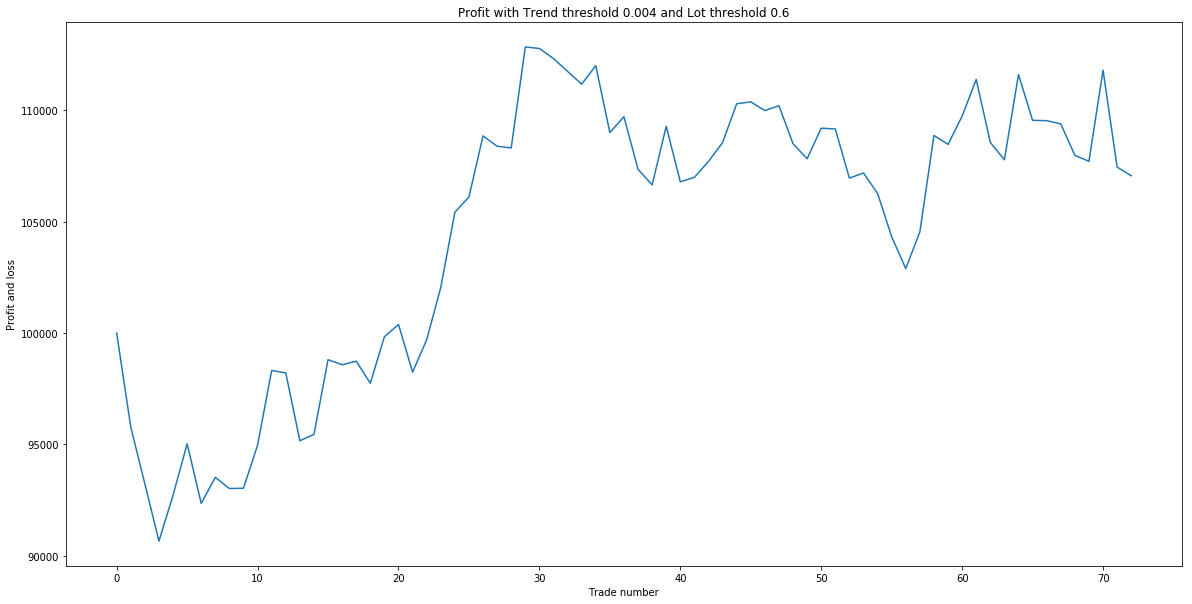

Trend threshold: 0.004 - CCI threshold: 180 - the lot threshold: 1.00 - Profit or loss:6654.25


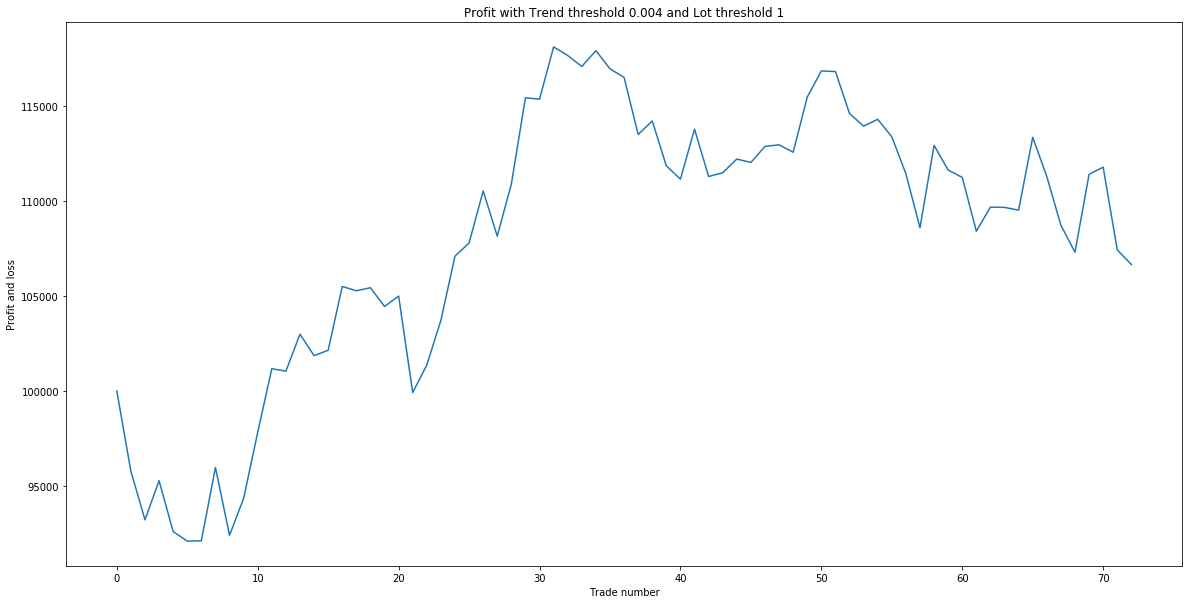

Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 0.60 - Profit or loss:4946.65


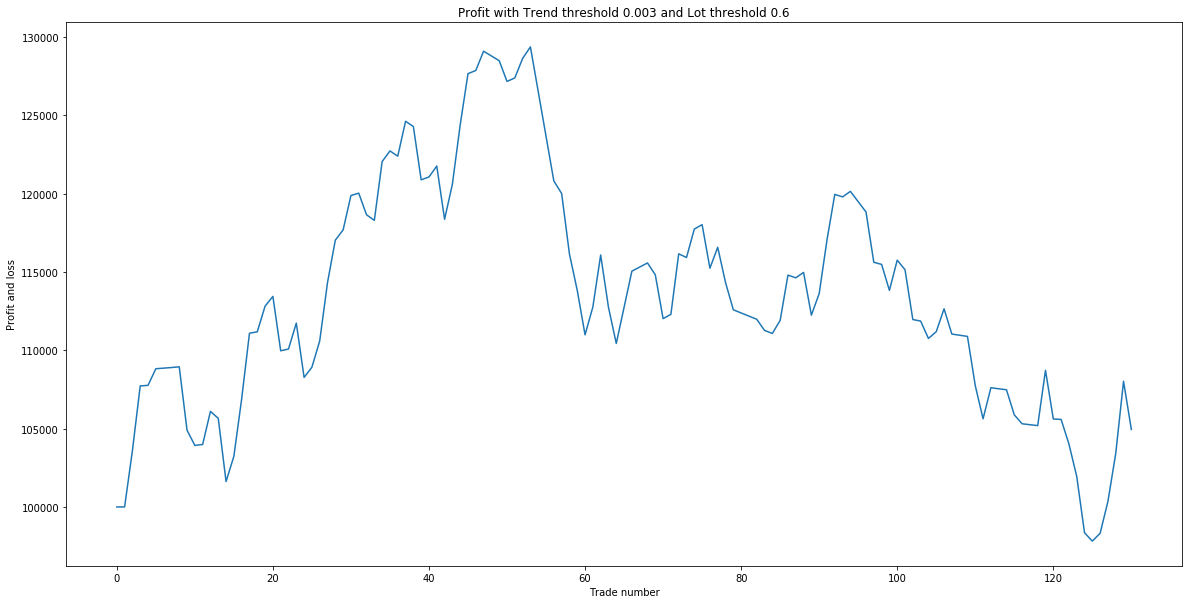

Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 1.00 - Profit or loss:7127.24


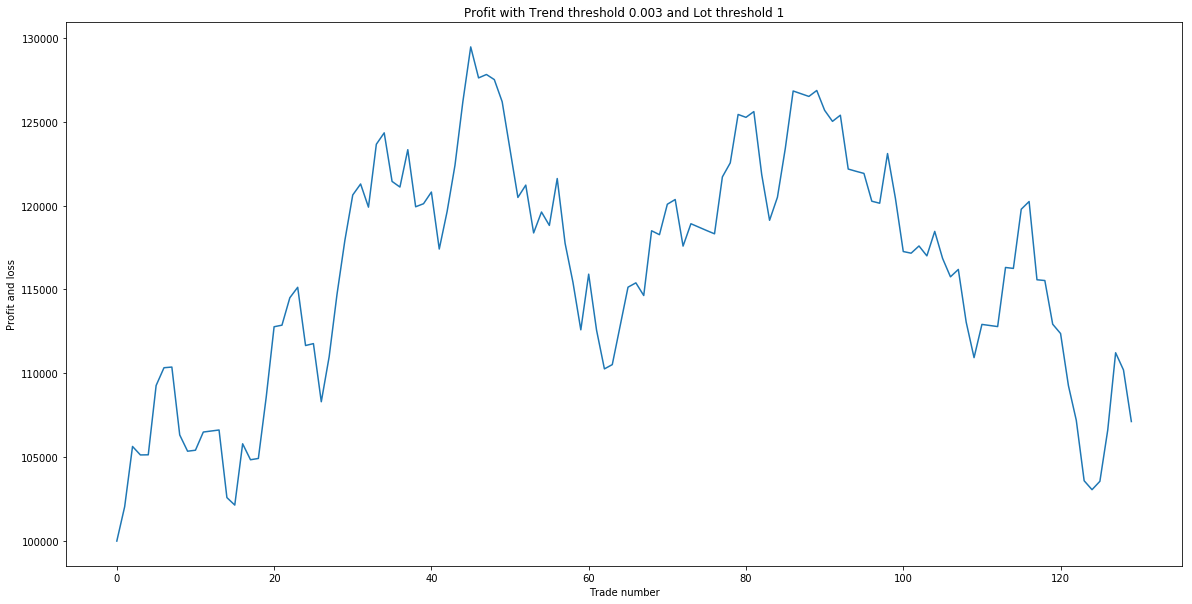

Trend threshold: 0.005 - CCI threshold: 180 - the lot threshold: 0.60 - Profit or loss:6920.94


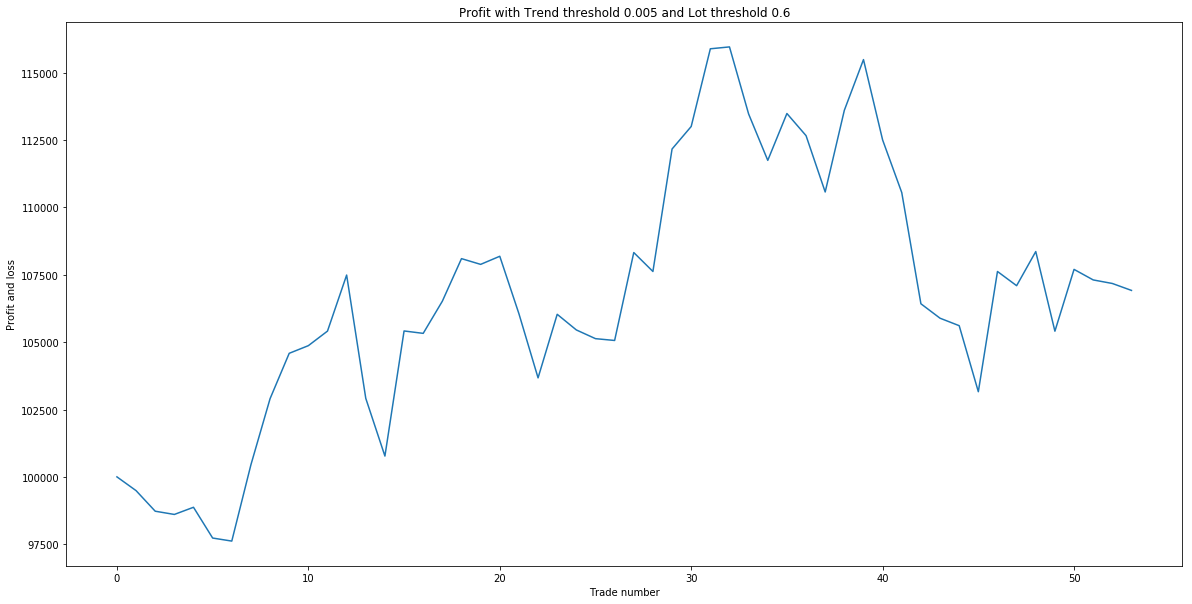

Trend threshold: 0.005 - CCI threshold: 180 - the lot threshold: 1.00 - Profit or loss:6101.29


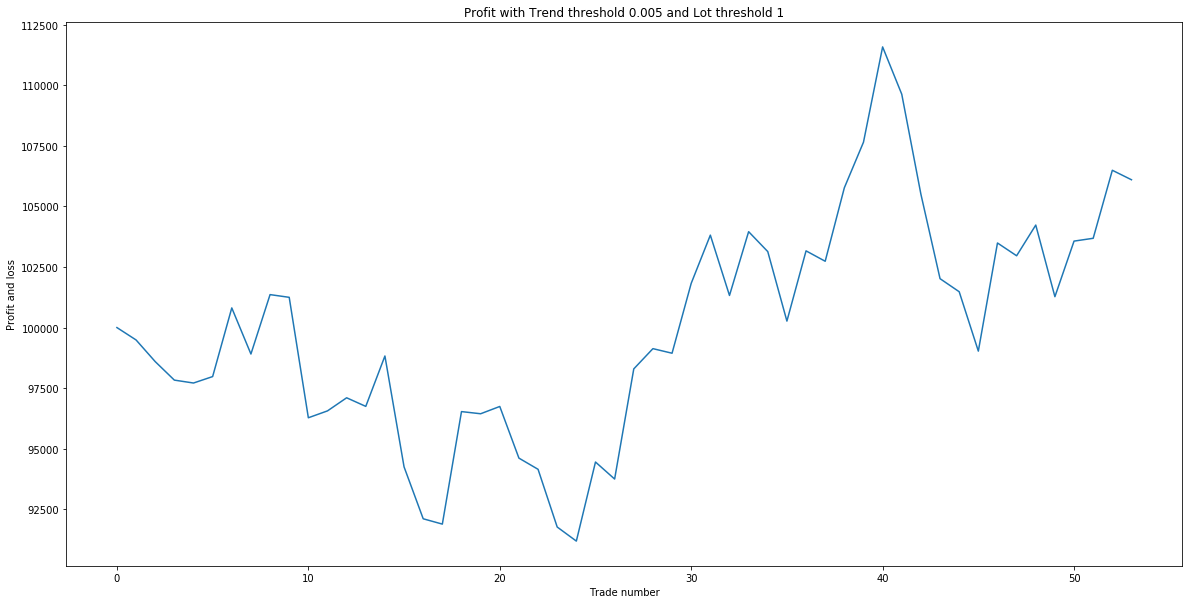

In [20]:
trend_threshold_set = {0.003,0.004,0.005}
CCI_threshold_set = {180}
ext_size_lot_set = {1,0.6}
w = 3
df_report_test_2 = df_report.copy()
# I tried to run a simulation from 25.10.2018  to 27.06.2019, with 1H timeframe.
for trend_threshold in trend_threshold_set:
    for CCI_threshold in CCI_threshold_set:
        for ext_size_lot in ext_size_lot_set:
            profit_loss = []
            final_profit_loss = []
            capital = 100000
            trade_order = 0
            size_order = 0
            take_profit_point = 0
            stop_loss_point = 0
            enter_price = 0
            last_pivot_price = 0
            pnl = 0
            remain_capital = []
            for i in range(1800,6000):
                data_trade = EU_Trade[i-600:i]
                data_trade.reset_index(inplace=True,drop=True)
                trend_trade = trend_v1(data_trade,trend_threshold,-trend_threshold)
                first_pivot_trade = trend_trade.initial_pivot()
                pivots_trade = trend_trade.peak_valley_pivots(first_pivot_trade)
                data_trade['Pivots'] = pivots_trade
                CCI_trade = ta.CCI(data_trade['High'], data_trade['Low'], data_trade['Close'], timeperiod=14)
                RSI_trade = ta.RSI(data_trade['Close'], timeperiod=14)
                data_trade['CCI'] = CCI_trade
                data_trade['RSI'] = RSI_trade
                df_trade = data_trade.where(data_trade['Pivots']!=0)
                df_trade = df_trade.dropna()
                df_trade = df_trade.reset_index(drop=True)

                d_trade = np.zeros(len(df_trade['Close']))
                for i in range(1,len(df_trade['Close'])):
                    d_trade[i] = df_trade['Close'][i] - df_trade['Close'][i-1]
                df_trade['Distance'] = d_trade

                #Check whether a new pivots points updated?
                if last_pivot_price != df_trade['Close'].iloc[-2]:
                    last_pivot_price = df_trade['Close'].iloc[-2]
                    #If yes, Close the current order, and update the it to the report
                    if trade_order == -1:
                        last_pivot_price = df_trade['Close'].iloc[-2]
                        pnl = -(enter_price - EU_Trade['Close'][i] ) * size_order
                        trade_order = 0
                    elif trade_order == 1:
                        last_pivot_price = df_trade['Close'].iloc[-2]
                        pnl = -(EU_Trade['Close'][i] - enter_price) * size_order
                        trade_order = 0
                    profit_loss.append(pnl)
                    pnl = 0    
                    #Predict the next move
                    df_next_move = df_trade[["CCI","RSI","Distance"]].tail(4)
                    df_next_move.reset_index(inplace=True,drop = True)
                    predict_win = WindowSlider(w)
                    predict_sett = predict_win.collect_windows(df_next_move.iloc[:,0:])
                    predict_distance = lr_model.predict(predict_sett.iloc[:,:-1])  
                    predict_sett = predict_sett.iloc[0:0]
                    #Enter Buy/Sell Order
                    #Buy order:
                    if df_trade['CCI'].iloc[-2] <= -CCI_threshold: #When market in Strongly oversold period
                        trade_order = 1
                        size_order = ext_size_lot * 100000 
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] - 0.002 
                        loss_d = stop_loss_point - enter_price
                        profit_d = predict_distance[0] - (enter_price - df_trade['Close'][i])
                        take_profit_point= enter_price + profit_d

                    elif 0 >= df_trade['CCI'].iloc[-2] > -CCI_threshold:  #When market in oversold period
                        trade_order = 1
                        size_order = 1 * 100000 #1lot
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] - 0.002 
                        loss_d = stop_loss_point - enter_price
                        profit_d = predict_distance[0] - (enter_price - df_trade['Close'][i])
                        take_profit_point= enter_price + profit_d

                    #Sell order:
                    elif df_trade['CCI'].iloc[-2] >= CCI_threshold: #When market in Strongly ovebought period
                        trade_order = -1
                        size_order = ext_size_lot * 100000 #
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] + 0.002 
                        loss_d = enter_price - stop_loss_point
                        profit_d = predict_distance[0] + (df_trade['Close'][i]-enter_price)
                        take_profit_point= df_trade['Close'][i] + profit_d

                    elif CCI_threshold > df_trade['CCI'].iloc[-2] > 0: #When market in ovebought period
                        trade_order = -1
                        size_order = 1 * 100000 #1 lot
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] + 0.002 
                        loss_d = enter_price - stop_loss_point
                        profit_d = predict_distance[0] + (df_trade['Close'][i]-enter_price)
                        take_profit_point= df_trade['Close'][i] + profit_d
                    #df_repor=df_report.append({'Order Type':trade_order,'Profit and loss':pnl},ignore_index=True)    
                else:
                    #if trade_order == 0:
                    #   break
                    #Check if a Buy order exist
                    if trade_order == 1:
                        if data_trade['High'][i] >= take_profit_point:
                            pnl = profit_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        elif data_trade['Low'][i] <= stop_loss_point:
                            pnl = loss_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        pnl = 0

                    elif trade_order == -1:
                        if data_trade['Low'][i] <= take_profit_point:
                            pnl = profit_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        elif data_trade['High'][i] >= stop_loss_point:
                            pnl = loss_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        pnl = 0              
                    #df_repor=df_report.append({'Order Type':trade_order,'Profit and loss':pnl},ignore_index=True)

            final_profit_loss = list(set(profit_loss))     
            print("Trend threshold: %.3f - CCI threshold: %d - the lot threshold: %.2f - Profit or loss:%.2f" %(trend_threshold,CCI_threshold,ext_size_lot,sum(final_profit_loss)))
            '''
            print(" -Number of trade is: %d" %len(final_profit_loss))
            print(" -The average gain per trade is: %.2f" %(sum(final_profit_loss)/len(final_profit_loss)))
            print(" -Max Loss in this in case is: %.2f" %min(final_profit_loss))
            print(" -Max Gain in this in case is: %.2f" %max(final_profit_loss))
            '''
            for i in range(len(final_profit_loss)):
                capital = capital + final_profit_loss[i]
                remain_capital.append(capital)
            fig, ax = plt.subplots(figsize = (20,10))
            ax.plot(remain_capital)
            ax.set_ylabel('Profit and loss')
            ax.set_xlabel('Trade number')
            ax.set_title('Profit with Trend threshold '+str(trend_threshold)+ ' and Lot threshold ' + str(ext_size_lot))
            plt.show()
            df_report_test_2=df_report_test_2.append({'Trend threshold':trend_threshold, 'CCI threshold':CCI_threshold, 'Lot size threshold':ext_size_lot,'Profit and loss':sum(final_profit_loss),'Number of trade':len(final_profit_loss),'Average gain per trade':(sum(final_profit_loss)/len(final_profit_loss)),'Max loss':min(final_profit_loss),'Max gain':max(final_profit_loss)}, ignore_index=True)
df_report_test_2.to_csv('df_report_test_2.csv')

In [21]:
df_report_test_2

,Trend threshold,CCI threshold,Lot size threshold,Profit and loss,Number of trade,Average gain per trade,Max loss,Max gain
0,0.004,180.0,0.6,7065.544880,73.0,96.788286,-4355.0,4538.0
1,0.004,180.0,1.0,6654.246474,73.0,91.154061,-5079.0,4538.0
2,0.003,180.0,0.6,4946.647505,131.0,37.760668,-4046.0,4603.0
3,0.003,180.0,1.0,7127.243630,130.0,54.824951,-4664.0,4603.0
4,0.005,180.0,0.6,6920.944404,54.0,128.165637,-4577.0,4644.0
5,0.005,180.0,1.0,6101.288044,54.0,112.986816,-4971.0,4644.0


<h4>In the test 2, we can see that:</h4>

    - Trend threshold 0.003 also gains the highest profit after all and number of trades, following 0.004 and 0.005.
    
    - Different from the test 1, trend threshold 0.003 now bring the lowest **max loss** and smallest **average gain per trade**
    
    - Now, The lot size threshold 0.6 gain the less **max loss** compared to 1.0 and in some case, the lot size threshold 0.6 gain much profits than than lot size threshold 1.0

<h4>After 2 tests, we can see that:</h4>

     - The trend threshold 0.003 usually gain the highest profit after all.
     
     - The lot size threshold in extreme market also plays a good role. Even we reduce nearly half of the amount of the money to enter the market, the profit is still higher.

<h4>In the last test, I am going to test the model in the most extremly market - when Corona Virus spread out period, from 17.02.2020  to 11.06.2020. The parameters I chose are  trend threshold {0.003, 0.004}, CCI {180}, lot size {1, 0.6}</h4>

In [22]:
EU_Trade[11999:12000]

,Local time,Open,High,Low,Close,Volume
11999,11.06.2020 23:00:00.000 GMT+0200,1.12989,1.13019,1.12922,1.12929,3262.575


Trend threshold: 0.004 - CCI threshold: 180 - the lot threshold: 0.60 - Profit or loss:7235.84


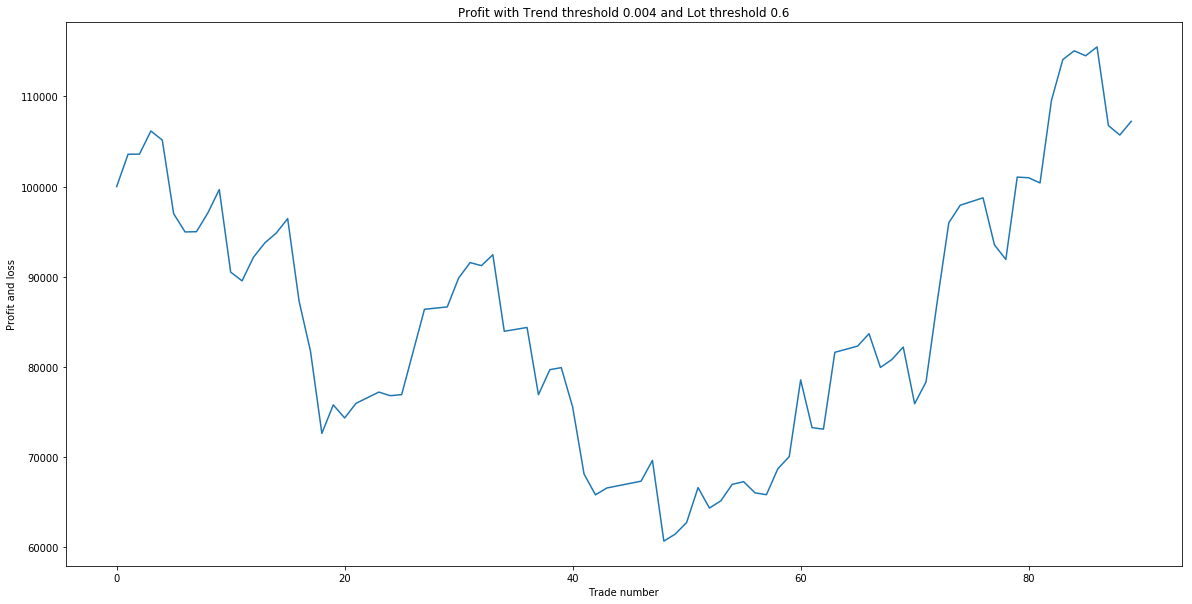

Trend threshold: 0.004 - CCI threshold: 180 - the lot threshold: 1.00 - Profit or loss:5891.64


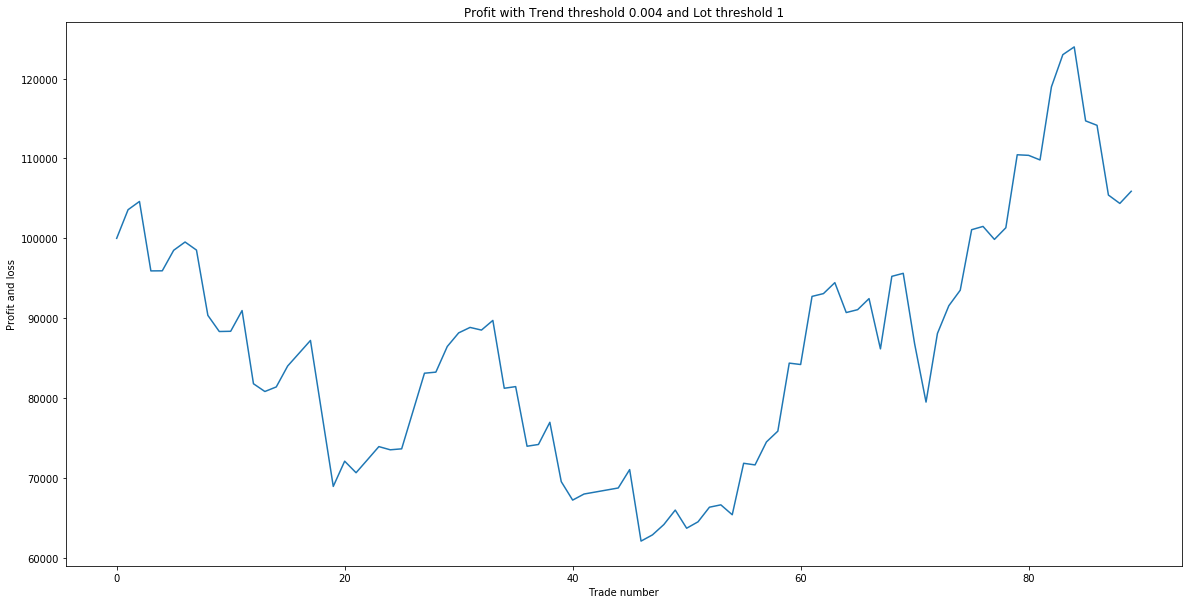

Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 0.60 - Profit or loss:74914.51


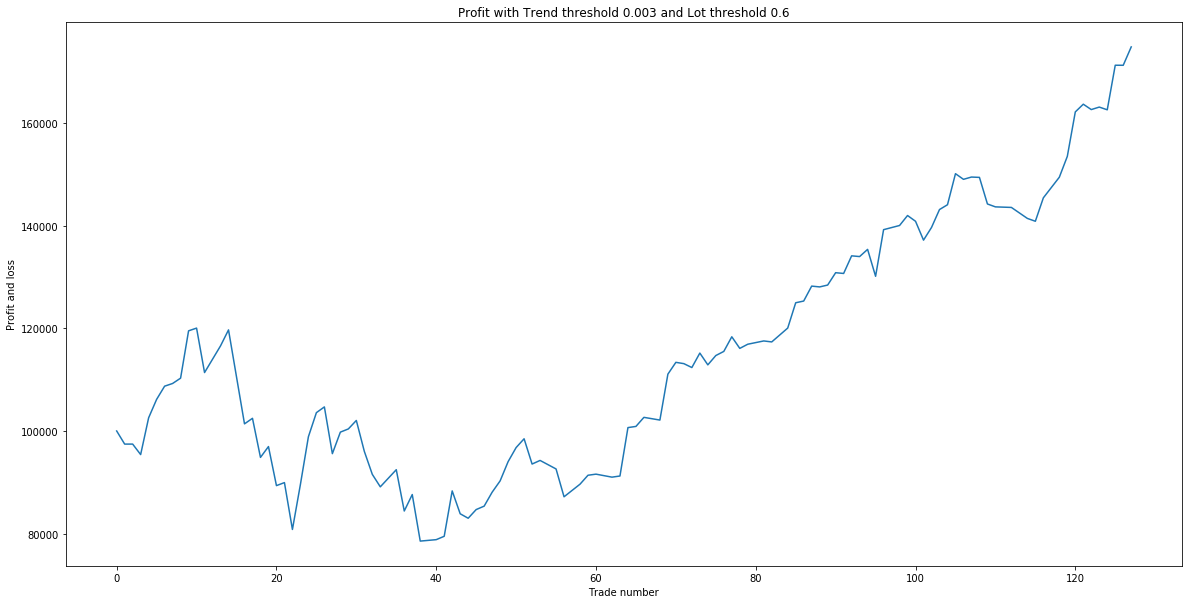

Trend threshold: 0.003 - CCI threshold: 180 - the lot threshold: 1.00 - Profit or loss:66091.73


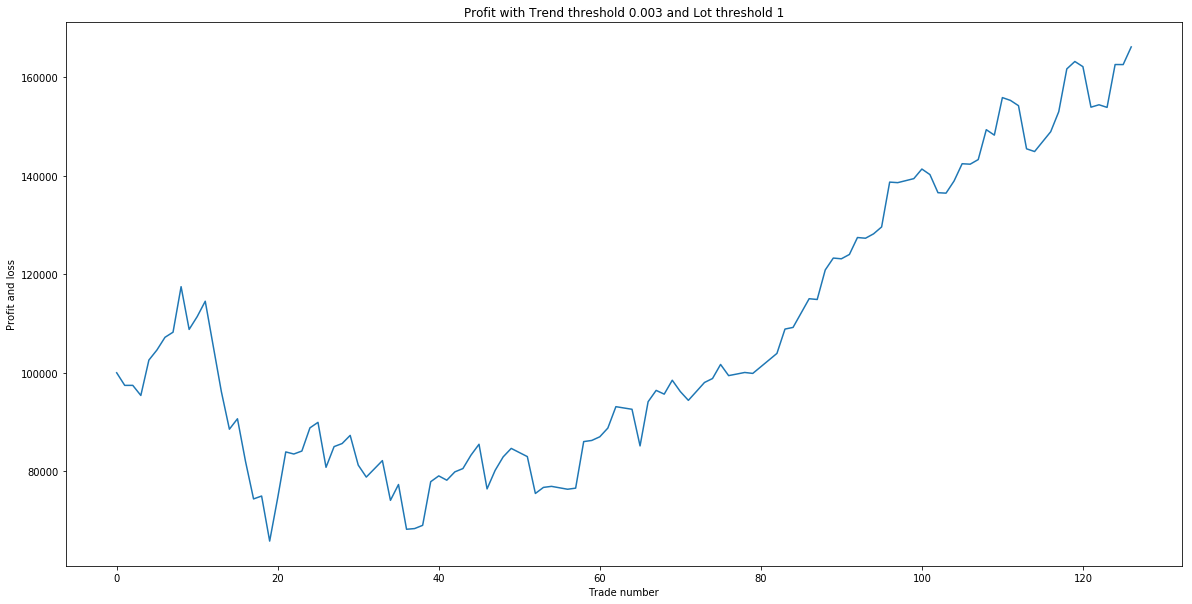

In [23]:
trend_threshold_set = {0.003,0.004}
CCI_threshold_set = {180}
ext_size_lot_set = {1,0.6}
w = 3
df_report_test_3 = df_report.copy()

# I tried to run a simulation from 17.02.2020  to 11.06.2020 , with 1H timeframe.
for trend_threshold in trend_threshold_set:
    for CCI_threshold in CCI_threshold_set:
        for ext_size_lot in ext_size_lot_set:
            profit_loss = []
            final_profit_loss = []
            capital = 100000
            trade_order = 0
            size_order = 0
            take_profit_point = 0
            stop_loss_point = 0
            enter_price = 0
            last_pivot_price = 0
            pnl = 0
            remain_capital = []
            for i in range(10000,12000):
                data_trade = EU_Trade[i-600:i]
                data_trade.reset_index(inplace=True,drop=True)
                trend_trade = trend_v1(data_trade,trend_threshold,-trend_threshold)
                first_pivot_trade = trend_trade.initial_pivot()
                pivots_trade = trend_trade.peak_valley_pivots(first_pivot_trade)
                data_trade['Pivots'] = pivots_trade
                CCI_trade = ta.CCI(data_trade['High'], data_trade['Low'], data_trade['Close'], timeperiod=14)
                RSI_trade = ta.RSI(data_trade['Close'], timeperiod=14)
                data_trade['CCI'] = CCI_trade
                data_trade['RSI'] = RSI_trade
                df_trade = data_trade.where(data_trade['Pivots']!=0)
                df_trade = df_trade.dropna()
                df_trade = df_trade.reset_index(drop=True)

                d_trade = np.zeros(len(df_trade['Close']))
                for i in range(1,len(df_trade['Close'])):
                    d_trade[i] = df_trade['Close'][i] - df_trade['Close'][i-1]
                df_trade['Distance'] = d_trade

                #Check whether a new pivots points updated?
                if last_pivot_price != df_trade['Close'].iloc[-2]:
                    last_pivot_price = df_trade['Close'].iloc[-2]
                    #If yes, Close the current order, and update the it to the report
                    if trade_order == -1:
                        last_pivot_price = df_trade['Close'].iloc[-2]
                        pnl = -(enter_price - EU_Trade['Close'][i] ) * size_order
                        trade_order = 0
                    elif trade_order == 1:
                        last_pivot_price = df_trade['Close'].iloc[-2]
                        pnl = -(EU_Trade['Close'][i] - enter_price) * size_order
                        trade_order = 0
                    profit_loss.append(pnl)
                    pnl = 0    
                    #Predict the next move
                    df_next_move = df_trade[["CCI","RSI","Distance"]].tail(4)
                    df_next_move.reset_index(inplace=True,drop = True)
                    predict_win = WindowSlider(w)
                    predict_sett = predict_win.collect_windows(df_next_move.iloc[:,0:])
                    predict_distance = lr_model.predict(predict_sett.iloc[:,:-1])  
                    predict_sett = predict_sett.iloc[0:0]
                    #Enter Buy/Sell Order
                    #Buy order:
                    if df_trade['CCI'].iloc[-2] <= -CCI_threshold: #When market in Strongly oversold period
                        trade_order = 1
                        size_order = ext_size_lot * 100000 
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] - 0.002 
                        loss_d = stop_loss_point - enter_price
                        profit_d = predict_distance[0] - (enter_price - df_trade['Close'][i])
                        take_profit_point= enter_price + profit_d

                    elif 0 >= df_trade['CCI'].iloc[-2] > -CCI_threshold:  #When market in oversold period
                        trade_order = 1
                        size_order = 1 * 100000 #1lot
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] - 0.002 
                        loss_d = stop_loss_point - enter_price
                        profit_d = predict_distance[0] - (enter_price - df_trade['Close'][i])
                        take_profit_point= enter_price + profit_d

                    #Sell order:
                    elif df_trade['CCI'].iloc[-2] >= CCI_threshold: #When market in Strongly ovebought period
                        trade_order = -1
                        size_order = ext_size_lot * 100000 #
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] + 0.002 
                        loss_d = enter_price - stop_loss_point
                        profit_d = predict_distance[0] + (df_trade['Close'][i]-enter_price)
                        take_profit_point= df_trade['Close'][i] + profit_d

                    elif CCI_threshold > df_trade['CCI'].iloc[-2] > 0: #When market in ovebought period
                        trade_order = -1
                        size_order = 1 * 100000 #1 lot
                        enter_price = data_trade['Close'][i]
                        stop_loss_point = df_trade['Close'].iloc[-2] + 0.002 
                        loss_d = enter_price - stop_loss_point
                        profit_d = predict_distance[0] + (df_trade['Close'][i]-enter_price)
                        take_profit_point= df_trade['Close'][i] + profit_d
                    #df_repor=df_report.append({'Order Type':trade_order,'Profit and loss':pnl},ignore_index=True)    
                else:
                    #if trade_order == 0:
                    #   break
                    #Check if a Buy order exist
                    if trade_order == 1:
                        if data_trade['High'][i] >= take_profit_point:
                            pnl = profit_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        elif data_trade['Low'][i] <= stop_loss_point:
                            pnl = loss_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        pnl = 0

                    elif trade_order == -1:
                        if data_trade['Low'][i] <= take_profit_point:
                            pnl = profit_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        elif data_trade['High'][i] >= stop_loss_point:
                            pnl = loss_d * size_order
                            trade_order = 0
                            profit_loss.append(pnl)
                        pnl = 0              
            final_profit_loss = list(set(profit_loss))
            print("Trend threshold: %.3f - CCI threshold: %d - the lot threshold: %.2f - Profit or loss:%.2f" %(trend_threshold,CCI_threshold,ext_size_lot,sum(final_profit_loss)))
            '''
            print(" -Number of trade is: %d" %len(final_profit_loss))
            print(" -The average gain per trade is: %.2f" %(sum(final_profit_loss)/len(final_profit_loss)))
            print(" -Max Loss in this in case is: %.2f" %min(final_profit_loss))
            print(" -Max Gain in this in case is: %.2f" %max(final_profit_loss))
            '''
            for i in range(len(final_profit_loss)):
                capital = capital + final_profit_loss[i]
                remain_capital.append(capital)
            fig, ax = plt.subplots(figsize = (20,10))
            ax.plot(remain_capital)
            ax.set_ylabel('Profit and loss')
            ax.set_xlabel('Trade number')
            ax.set_title('Profit with Trend threshold '+str(trend_threshold)+ ' and Lot threshold ' + str(ext_size_lot))
            plt.show()
            df_report_test_3=df_report_test_3.append({'Trend threshold':trend_threshold, 'CCI threshold':CCI_threshold, 'Lot size threshold':ext_size_lot,'Profit and loss':sum(final_profit_loss),'Number of trade':len(final_profit_loss),'Average gain per trade':(sum(final_profit_loss)/len(final_profit_loss)),'Max loss':min(final_profit_loss),'Max gain':max(final_profit_loss)}, ignore_index=True)
df_report_test_3.to_csv('df_report_test_3.csv')

In [24]:
df_report_test_3

,Trend threshold,CCI threshold,Lot size threshold,Profit and loss,Number of trade,Average gain per trade,Max loss,Max gain
0,0.004,180.0,0.6,7235.836010,90.0,80.398178,-9167.0,9152.0
1,0.004,180.0,1.0,5891.637232,90.0,65.462636,-9266.0,9152.0
2,0.003,180.0,0.6,74914.507916,128.0,585.269593,-9170.0,9442.0
3,0.003,180.0,1.0,66091.730303,127.0,520.407325,-9170.0,9442.0


WoW! Amazing! I did not expect that we can gain much money during this period!

As we can see from the result:
    
    - The trend threshold 0.003 gain much higher than the trend threshold 0.004.
    
    - Lot size threshold 0.6 bring higher profit than 1.0.
    
    - Looking deeply into the charts, in the first period of trading, when the Covid 19 started spreading out, both model show the loss, but with lot size 0.6, it prevented the bigger loss.

Discussion:


        - The combination between Pivot point, Sliding window and Multiple Linear regression has gained profit!
        
        - The ideal trendthreshold is around 0.003.
        
        - The lot size threshold in extreme market is strictly needed to prevent big loss. 

Future work:
        
        - All testing parameters is applied to the currency pair EURO/USD in timeframe 1 Hour. Thus any change in currency pair and timeframe must modify the parameter.
        
        - Impliment the fundamental indicator to detect the very important events such as Payr